# 5.¿Cómo  se  distribuyen  las  especies  fósiles  en las regiones de chile según  sus  hábitos alimenticios, y qué nos puede decir esto sobre la estructura ecológica de la región en diferentes períodos geológicos?

### 1. Importación y preparación de datos

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
import os
import seaborn as sns

In [5]:
# Cargar el dataset principal ya limpio
chile_df = pd.read_csv('data_clean/chile_clean.csv')

# Verificar las columnas disponibles para decidir qué usar
print("Columnas en el dataset principal:", chile_df.columns)

Columnas en el dataset principal: Index(['species_name', 'occurrence_no', 'accepted_name', 'phylum', 'class',
       'order', 'family', 'genus', 'lat', 'lng', 'diet', 'life_habit',
       'environment', 'taxon_environment', 'primary_name', 'era_early',
       'era_late'],
      dtype='object')


In [6]:
# Seleccionar columnas relevantes para el análisis
columns_to_use = ['diet', 'lat', 'lng', 'era_early', 'era_late']
df_diet = chile_df[columns_to_use]

In [7]:
# Copiar los datos seleccionados para trabajar
df_diet = df_diet.copy()

# Filtrar valores nulos en coordenadas (latitud y longitud)
df_diet = df_diet[df_diet['lat'].notnull() & df_diet['lng'].notnull()]

# Crear geometrías a partir de las coordenadas
geometry = [Point(xy) for xy in zip(df_diet['lng'], df_diet['lat'])]
chile_geo_df = gpd.GeoDataFrame(df_diet, geometry=geometry, crs="EPSG:4326")

In [25]:
df_diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9481 entries, 0 to 9480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   diet       8749 non-null   object 
 1   lat        9481 non-null   float64
 2   lng        9481 non-null   float64
 3   era_early  9481 non-null   object 
 4   era_late   9481 non-null   object 
dtypes: float64(2), object(3)
memory usage: 370.5+ KB


No se eliminaran las filas que tienen valores nulos en las dietas, ya que se reducian como 700 lineas, las caules nos pueden ayudar en la distribucion de fosiles por era.

In [8]:
# Ver los valores únicos en la columna 'diet'.
unique_diets = df_diet['diet'].unique()
print(unique_diets)

# Ver también la cantidad de veces que aparece cada valor.
diet_counts = df_diet['diet'].value_counts()
print(diet_counts)

['deposit feeder, suspension feeder' 'deposit feeder' 'suspension feeder'
 'grazer' 'chemosymbiotic' 'chemosymbiotic, suspension feeder' 'omnivore'
 'carnivore' nan 'herbivore' 'microcarnivore, photosymbiotic'
 '"photoautotroph"' 'C3 autotroph' 'photosymbiotic, suspension feeder'
 'detritivore' 'insectivore' 'omnivore, grazer' 'grazer, carnivore'
 'piscivore, carnivore' 'piscivore' 'browser' 'grazer, browser'
 'carnivore, omnivore' 'frugivore, folivore'
 'carnivore, suspension feeder' 'deposit feeder, detritivore'
 'microcarnivore' 'grazer, deposit feeder'
 'detritivore, suspension feeder' 'carnivore, detritivore'
 'grazer, omnivore' 'durophage, carnivore' 'durophage, piscivore'
 'frugivore' 'herbivore, carnivore' 'suspension feeder, detritivore'
 'suspension feeder, carnivore' 'insectivore, carnivore' 'browser, grazer'
 'frugivore, granivore' 'insectivore, frugivore' 'granivore'
 'carnivore, parasite' 'browser, browser']
diet
suspension feeder                    4666
carnivore        

In [9]:
# Cargar los shapefiles de regiones y comunas
gdf_regiones = gpd.read_file(r'data/Regiones/Regional.shp').to_crs("EPSG:4326")
gdf_comunas = gpd.read_file(r'data/Comunas_chile/comunas.shp').to_crs("EPSG:4326")

# Hacer la unión espacial para agregar información de regiones al GeoDataFrame
chile_geo_df = gpd.sjoin(chile_geo_df, gdf_regiones, how='inner', predicate='within')

# Verificar las primeras filas del GeoDataFrame
print("Primeras filas del GeoDataFrame procesado:")
print(chile_geo_df.head())

Primeras filas del GeoDataFrame procesado:
                                diet   lat   lng   era_early         era_late  \
0  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
1  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
2  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
3                     deposit feeder -37.0 -73.0  Cretaceous  No especificado   
4                     deposit feeder -37.0 -73.0  Cretaceous  No especificado   

          geometry  index_right  objectid  cir_sena  codregion       area_km  \
0  POINT (-73 -37)           12      1096        10          8  24021.621594   
1  POINT (-73 -37)           12      1096        10          8  24021.621594   
2  POINT (-73 -37)           12      1096        10          8  24021.621594   
3  POINT (-73 -37)           12      1096        10          8  24021.621594   
4  POINT (-73 -37)           12      1096        10          8  24021.

# 2. Limpieza y análisis descriptivo

### Lógica de Agrupación por dieta.
1. Filtros y Suspensores:
    -   Agrupa organismos que obtienen su alimento del agua o sedimentos mediante filtración o suspensión. Esto incluye aquellos que pueden tener características de alimentación tanto de depósitos como de suspensión.
2. Consumidores Primarios:
    -    Incluye organismos que se alimentan directamente de productores (plantas, algas) o fuentes primarias de alimento. Son generalmente herbívoros y se agrupan por su dieta de materia vegetal o frutas.
3. Consumidores Secundarios (Carnívoros):
    -    Comprende los organismos que se alimentan de otros animales. Esta categoría incluye varios tipos de carnívoros, desde depredadores generales hasta especializados (como piscívoros, que se alimentan de peces).
4. Omnívoros:
    -    Agrupa organismos que consumen tanto materia vegetal como animal. Esta categoría puede incluir aquellos que tienen dietas variadas y que no se limitan a un solo tipo de alimento.
5. Descomponedores y Detritívoros:
    -    Incluye organismos que se alimentan de materia orgánica en descomposición. Los detritívoros son esenciales para el reciclaje de nutrientes en los ecosistemas.
6. Simbiontes y Especializados:
    -    Agrupa organismos que tienen relaciones simbióticas o que dependen de procesos biológicos específicos para su alimentación, como los que obtienen energía a través de reacciones químicas (quimiosíntesis).
7. Otros Combinados:
    -    Incluye aquellos organismos que tienen dietas mixtas que no se ajustan claramente a las categorías anteriores. Estos pueden ser carnívoros que también consumen material vegetal o viceversa.

In [10]:
# Listas de estrategias alimentarias
filtros_y_suspensores = [
    'deposit feeder, suspension feeder',
    'suspension feeder',
    'photosymbiotic, suspension feeder',
    'detritivore, suspension feeder',
    'carnivore, suspension feeder'
]

consumidores_primarios = [
    'grazer',
    'herbivore',
    'frugivore',
    'granivore',
    'browser',
    'browser, grazer'
]

consumidores_secundarios = [
    'carnivore',
    'microcarnivore',
    'piscivore',
    'insectivore',
    'durophage, carnivore',
    'insectivore, carnivore',
    'carnivore, omnivore',
    'carnivore, parasite'
]

omnivoros = [
    'omnivore',
    'omnivore, grazer',
    'herbivore, carnivore',
    'frugivore, folivore',
    'grazer, omnivore'
]

descomponedores_y_detritivoros = [
    'detritivore',
    'deposit feeder, detritivore',
    'grazer, deposit feeder',
    'detritivore, suspension feeder'
]

simbiontes_y_especializados = [
    'chemosymbiotic',
    'chemosymbiotic, suspension feeder',
    'microcarnivore, photosymbiotic',
    '"photoautotroph"',
    'C3 autotroph'
]

#Lo agrego mejor a omnivoros?
otros_combinados = [
    'grazer, carnivore',
    'piscivore, carnivore',
    'durophage, piscivore',
    'insectivore, frugivore'
]

In [11]:
def categorize_diet(diet):
    if pd.isna(diet):
        return 'incertidumbre'
    
    diet = diet.lower()
    
    categories = {
        'filtros y suspensores': filtros_y_suspensores,
        'consumidores primarios': consumidores_primarios,
        'consumidores secundarios': consumidores_secundarios,
        'omnivoros': omnivoros,
        'descomponedores y detritívoros': descomponedores_y_detritivoros,
        'simbiontes y especializados': simbiontes_y_especializados,
        'otros combinados': otros_combinados,
    }
    
    for category, items in categories.items():
        if diet in items:
            return category
    
    return 'otros'


In [12]:
# Aplicar la categorización al DataFrame
chile_geo_df['diet_grouped'] = chile_geo_df['diet'].apply(categorize_diet)
# Verificar las agrupaciones
print("Conteo por grupos de dieta:")
print(chile_geo_df['diet_grouped'].value_counts())


Conteo por grupos de dieta:
diet_grouped
filtros y suspensores             4718
consumidores secundarios          2183
incertidumbre                      707
consumidores primarios             502
simbiontes y especializados        323
omnivoros                          319
otros                              148
descomponedores y detritívoros      50
otros combinados                    33
Name: count, dtype: int64


# 3. Visualización geográfica

## Mapeo por dieta en Chile:

In [13]:
def mapear_dietas(df_diet, gdf_comunas, columna_dieta='diet_grouped', titulo="Distribución de Dietas en Chile"):
    # Filtrar datos con coordenadas válidas
    df_diet = df_diet[df_diet['lat'].notnull() & df_diet['lng'].notnull()]
    geometry = [Point(xy) for xy in zip(df_diet['lng'], df_diet['lat'])]
    
    # Crear GeoDataFrame
    chile_geo_df = gpd.GeoDataFrame(df_diet, geometry=geometry, crs="EPSG:4326")
    colores = {
        'filtros y suspensores': 'blue',
        'consumidores primarios': 'green',
        'consumidores secundarios': 'red',
        'omnivoros': 'orange',
        'descomponedores y detritívoros': 'purple',
        'simbiontes y especializados': 'cyan',
        'otros combinados': 'magenta'
    }

    # Configuración de colores
    if colores is None:
        categorias = chile_geo_df[columna_dieta].unique()
        colores = {cat: plt.cm.get_cmap('tab20')(i / len(categorias)) for i, cat in enumerate(categorias)}
    
    # Crear el gráfico
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf_comunas.plot(ax=ax, color='lightgrey', edgecolor='black')  # Fondo de las comunas

    for dieta, color in colores.items():
        subset = chile_geo_df[chile_geo_df[columna_dieta] == dieta]
        if not subset.empty:  # Evitar errores con conjuntos vacíos
            subset.plot(ax=ax, color=color, markersize=10, label=dieta, alpha=0.6)
    
    # Ajustes visuales
    ax.set_aspect('equal')
    plt.legend(title=columna_dieta, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(titulo, fontsize=16)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()


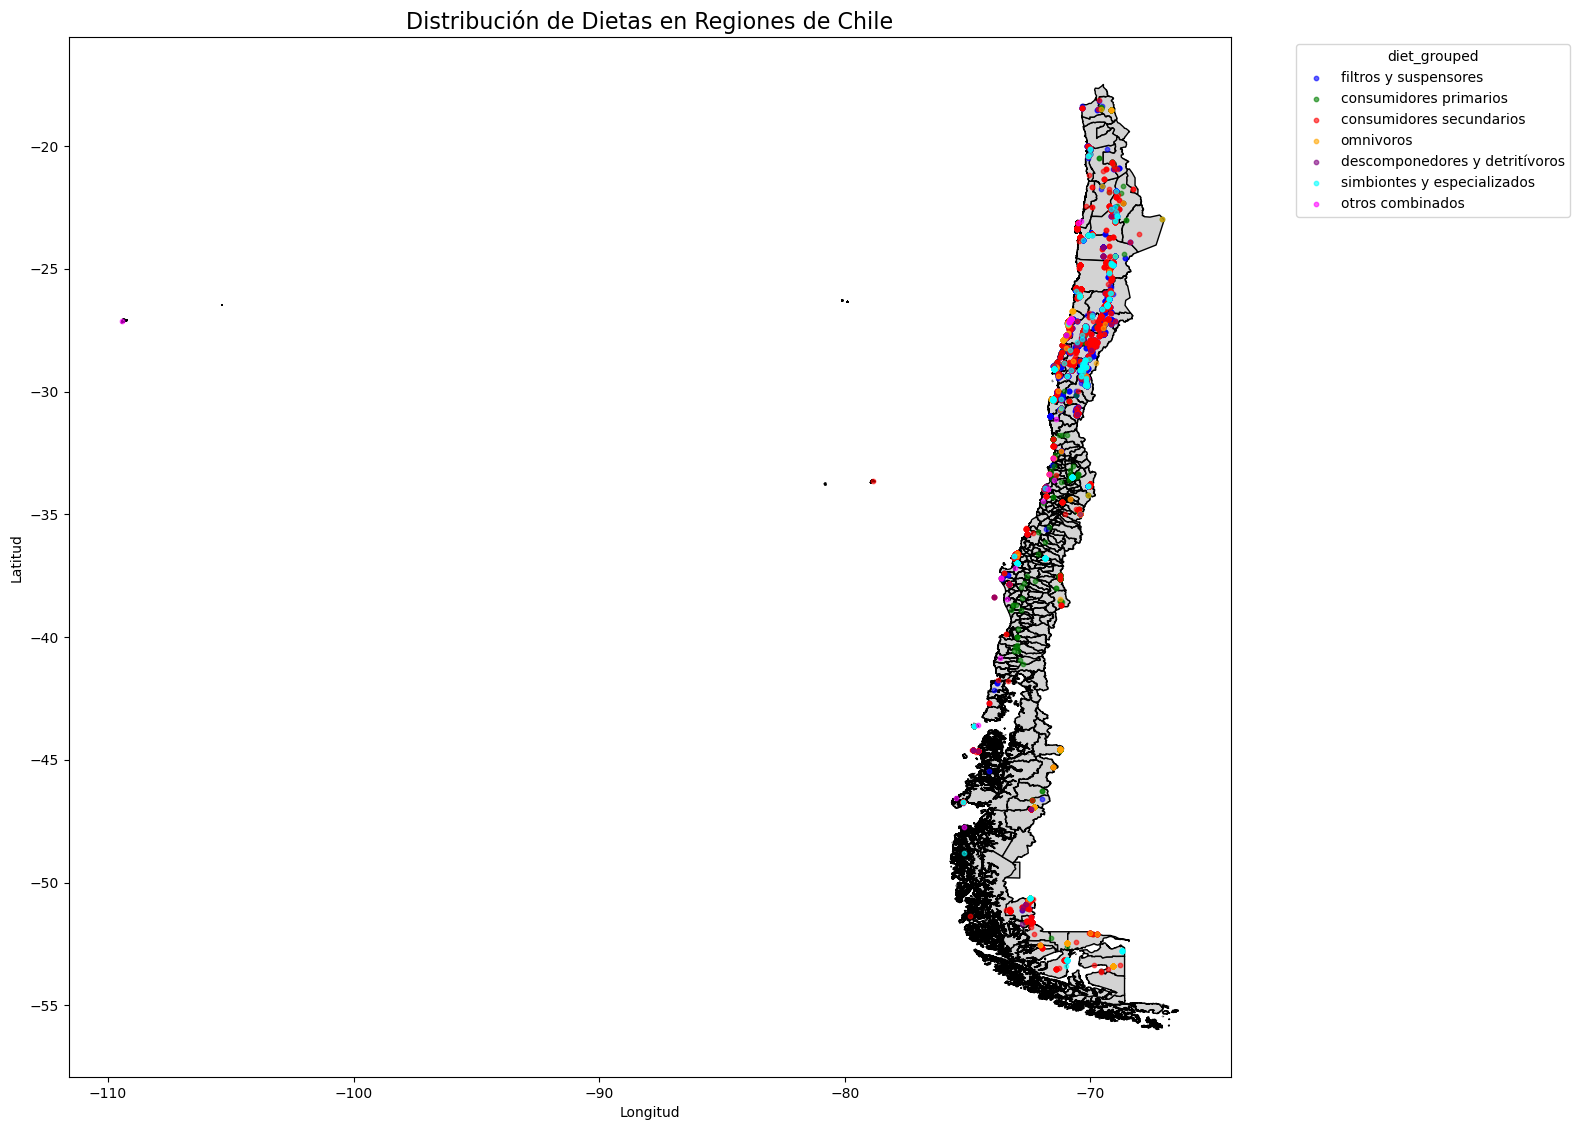

In [14]:
# Llamar a la función para graficar el mapa con las dietas
mapear_dietas(chile_geo_df, gdf_comunas,'diet_grouped',"Distribución de Dietas en Regiones de Chile")

### Mapear por regiones especificas de Chile:

In [15]:
def plot_regions_and_communes(region_names, gdf_regiones, gdf_comunas, chile_geo_df):
    regions_shape = gdf_regiones[gdf_regiones['Region'].isin(region_names)]
    comunas_shape = gdf_comunas[gdf_comunas['Region'].isin(region_names)]
    regions_fossils = chile_geo_df[chile_geo_df['Region'].isin(region_names)]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    regions_shape.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
    comunas_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    
    colors = {
        'filtros y suspensores': 'blue',
        'consumidores primarios': 'green',
        'consumidores secundarios': 'red',
        'omnivoros': 'orange',
        'descomponedores y detritívoros': 'purple',
        'simbiontes y especializados': 'cyan',
        'otros combinados': 'magenta',
    }
    
    for diet, color in colors.items():
        subset = regions_fossils[regions_fossils['diet_grouped'] == diet]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=10, label=diet, alpha=0.6)
    
    plt.legend()
    plt.title(f"Fósiles por habito alimenticio en la Región {region_names}", fontsize=14)
    plt.show()


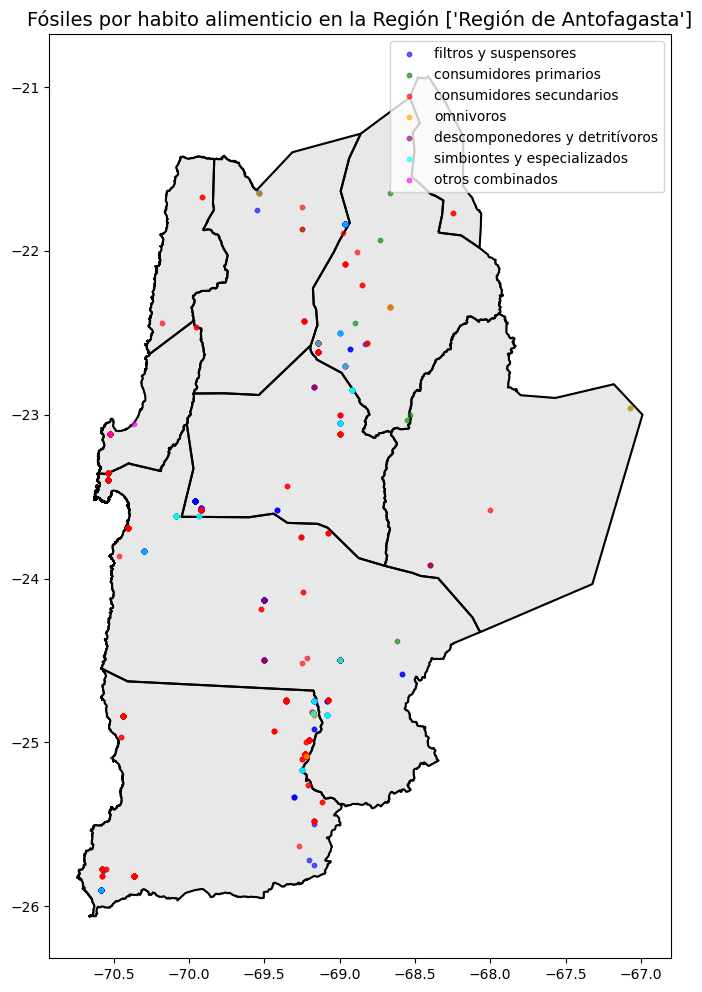

In [16]:
plot_regions_and_communes(['Región de Antofagasta'], gdf_regiones, gdf_comunas, chile_geo_df)

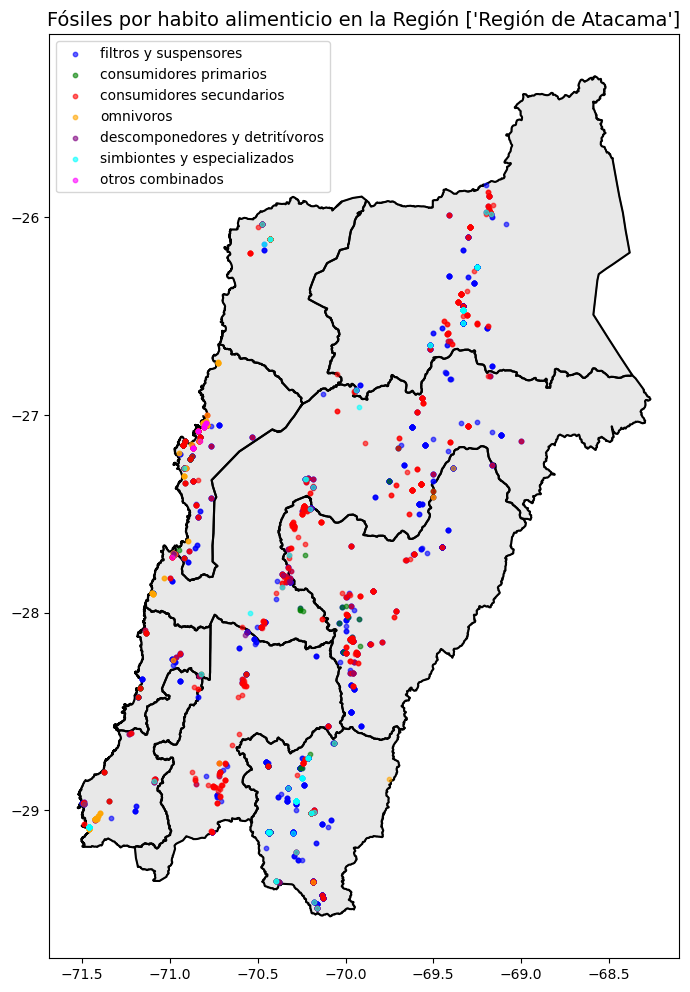

In [17]:

plot_regions_and_communes(['Región de Atacama'], gdf_regiones, gdf_comunas, chile_geo_df)

### Fósiles agrupados por dieta

In [18]:
def plot_diet_distribution(df, title="Distribución de Dietas"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='diet_grouped', order=df['diet_grouped'].value_counts().index, palette="viridis")
    plt.title(title)
    plt.xlabel("Cantidad de Fósiles")
    plt.ylabel("Grupo de Dietas")
    plt.show()

C:\Users\FZ6\AppData\Local\Temp\ipykernel_5352\2026075114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='diet_grouped', order=df['diet_grouped'].value_counts().index, palette="viridis")


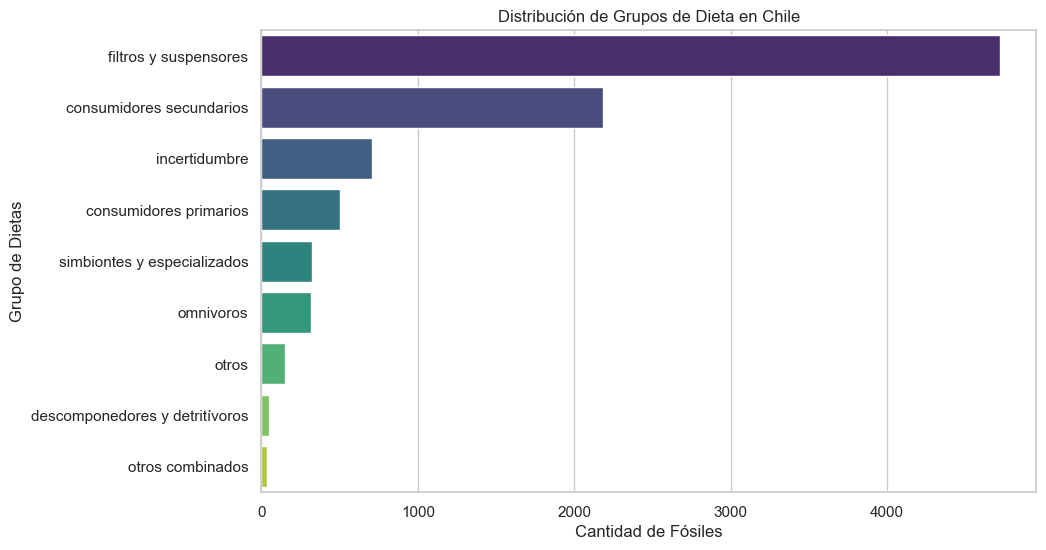

In [19]:
# Distribución de Dietas
plot_diet_distribution(chile_geo_df, "Distribución de Grupos de Dieta en Chile")


# Mapear por era

In [20]:

def plot_fossils_by_era(region_name, gdf_regiones, gdf_comunas, chile_geo_df, top_n=5):
    """
    Gráfica fósiles en una región agrupados por las épocas más representativas y añade las comunas.
    """
    region_shape = gdf_regiones[gdf_regiones['Region'] == region_name]
    if region_shape.empty:
        print(f"La región '{region_name}' no existe en el shapefile.")
        return
    
    region_fossils = chile_geo_df[chile_geo_df['Region'] == region_name]
    top_eras = region_fossils.groupby('era_early')['diet'].nunique().nlargest(top_n)
    print(f"Top {top_n} épocas con más especies únicas en la región {region_name}:")
    print(top_eras)
    
    filtered_fossils = region_fossils[region_fossils['era_early'].isin(top_eras.index)]

    # Configurar el gráfico
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    region_shape.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
    
    comunas_shape = gdf_comunas[gdf_comunas['Region'] == region_name]
    comunas_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    # Definir colores fijos para cada era
    fixed_colors = {
        'Cretaceous': 'orange',
        'Neogene': 'green',
        'Paleogene': 'blue',
        'Jurassic': 'red',
        'Triassic': 'purple',
        'Permian': 'cyan',
        'Carboniferous': 'magenta',
        # Agrega más eras y colores según sea necesario
    }
    # Graficar fósiles por época usando colores fijos
    for era in top_eras.index:
        subset = filtered_fossils[filtered_fossils['era_early'] == era]
        if era in fixed_colors:
            color = fixed_colors[era]
        else:
            color = 'black'  # Color por defecto si la era no está en el diccionario
        subset.plot(ax=ax, color=color, markersize=12, label=era, alpha=0.8)
    
    plt.legend(title="Época", loc='upper right')
    plt.title(f"Fósiles por Época en la Región {region_name}", fontsize=14)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()

def plot_fossils_by_era_in_zones(zones, gdf_regiones, gdf_comunas, chile_geo_df, top_n=5):
    """
    Graficar fósiles en zonas (Norte, Centro, Sur) agrupados por épocas más representativas.
    """
    for zone in zones:
        for region in zone:
            print(f"Graficando para la región: {region}")
            plot_fossils_by_era(region, gdf_regiones, gdf_comunas, chile_geo_df, top_n)

In [21]:
# Clasificar las regiones en Norte, Centro y Sur
norte = [
    'Región de Arica y Parinacota',
    'Región de Tarapacá',
    'Región de Antofagasta',
    'Región de Atacama',
    'Región de Coquimbo'
]

centro = [
    'Región de Valparaíso',
    'Región Metropolitana de Santiago',
    "Región del Libertador Bernardo O'Higgins",
    'Región del Maule',
    'Región de Ñuble',
    'Región del Bío-Bío'
]

sur = [
    'Región de La Araucanía',
    'Región de Los Ríos',
    'Región de Los Lagos',
    'Región de Aysén del Gral. Ibañez del Campo',
    'Región de Magallanes y Antártica Chilena'
]

In [ ]:
# Llamar a la función para graficar fósiles por era en las zonas Norte, Centro y Sur (mostrara cada region!)
#plot_fossils_by_era_in_zones([norte], gdf_regiones, gdf_comunas, chile_geo_df, top_n=5)

### Fósiles agrupados por era

In [23]:
# Función para graficar fósiles agrupados por era
def plot_era_distribution(df, title="Distribución de Fósiles por Era"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='era_early', kde=False, bins=20, color='skyblue')
    plt.title(title)
    plt.xlabel("Era (Millones de Años)")
    plt.ylabel("Cantidad de Fósiles")
    plt.show()

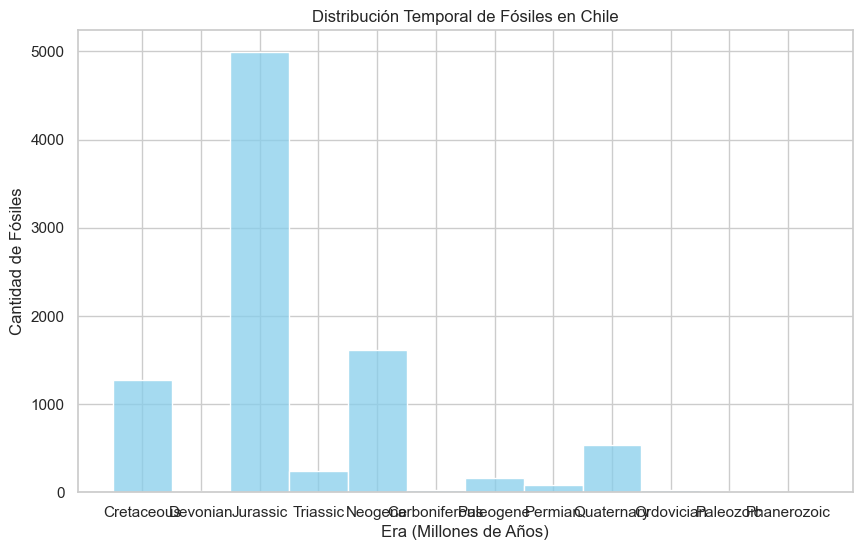

In [24]:
#Distribución de Fósiles por Era
plot_era_distribution(chile_geo_df, "Distribución Temporal de Fósiles en Chile")

# 4. Clustering

# 5. Análisis de distribuciones

# Resultados y conclusiones
